In [1]:
!pip install nibabel

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.transforms import RandomAffine

warnings.filterwarnings('ignore')

In [3]:
class BasicBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(out_channels)
            )
            
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(out_channels, out_channels//16, kernel_size=1),
            nn.ReLU(),
            nn.Conv3d(out_channels//16, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x = x * self.se(x)
        x += self.shortcut(residual)
        return F.relu(x)

In [4]:
class ResNet14_3D(nn.Module):
    def __init__(self, num_classes=2, in_channels=1):
        super().__init__()
        self.in_channels = in_channels

        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.maxpool = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        
        self.layers = nn.Sequential(
            self._make_layer(64, 64, stride=1),
            self._make_layer(64, 128, stride=1),
            self._make_layer(128, 256, stride=2),
            self._make_layer(256, 512, stride=2)
        )
        
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            BasicBlock3D(in_channels, out_channels, stride),
            BasicBlock3D(out_channels, out_channels, stride=1)
        )

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layers(x)
        x = self.avgpool(x)
        return torch.flatten(x, 1)

In [5]:
class MultiModalAttention(nn.Module):
    def __init__(self, dim, num_heads=8):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim // num_heads
        
        self.W_q = nn.Linear(dim, dim)
        self.W_k = nn.Linear(dim, dim)
        self.W_v = nn.Linear(dim, dim)
        self.out = nn.Linear(dim, dim)
        
    def forward(self, mri_feat, dti_feat):
        B = mri_feat.size(0)
        q = self.W_q(mri_feat).view(B, self.num_heads, self.dim_head)
        k = self.W_k(dti_feat).view(B, self.num_heads, self.dim_head)
        v = self.W_v(dti_feat).view(B, self.num_heads, self.dim_head)
        
        attn_scores = torch.einsum('bhd,bhd->bh', q, k) / (self.dim_head ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        attended = torch.einsum('bh,bhd->bhd', attn_weights, v)
        attended = attended.reshape(B, -1)
        return self.out(attended)

In [6]:
class MADNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        
        self.mri_branch = nn.Sequential(
            ResNet14_3D(in_channels=1),
            nn.Dropout(0.4)
        )
        
        self.dti_branch = nn.Sequential(
            ResNet14_3D(in_channels=1),
            nn.Dropout(0.4)
        )

        self.demo_fc = nn.Sequential(
            nn.Linear(2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.attention = MultiModalAttention(512, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(512 + 128, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(512, num_classes)
        )

    def forward(self, mri, dti, age, gender):
        mri_feat = self.mri_branch(mri)
        dti_feat = self.dti_branch(dti)
        
        fused = self.attention(mri_feat, dti_feat)
        
        demo = torch.cat([age.unsqueeze(1), gender.unsqueeze(1)], dim=1)
        demo_feat = self.demo_fc(demo)
        
        combined = torch.cat((fused, demo_feat), dim=1)
        return self.classifier(combined)

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        focal_loss = (1 - pt).clamp(min=1e-7)**self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        return focal_loss.mean()

In [8]:
class MedicalDataset(Dataset):
    def __init__(self, df, data_dir, target_shape=(182, 182, 10), is_train=False):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.target_shape = target_shape
        self.is_train = is_train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        mri_fp = os.path.join(self.data_dir, row['mri_link'], 'image.nii').replace('\\', '/')
        dti_fp = os.path.join(self.data_dir, row['dti_link'], 'image.nii').replace('\\', '/')

        def load_nifti(path):
            arr = nib.load(path).get_fdata().astype(np.float32)
            return (arr - arr.mean()) / (arr.std() + 1e-8)

        mri_vol = load_nifti(mri_fp)
        dti_vol = load_nifti(dti_fp)

        # Resize bằng crop/pad
        def resize_vol(vol, shape):
            tz, ty, tx = shape
            z, y, x = vol.shape
            cz, cy, cx = min(z, tz), min(y, ty), min(x, tx)
            sz, sy, sx = (z-cz)//2, (y-cy)//2, (x-cx)//2
            dz, dy, dx = (tz-cz)//2, (ty-cy)//2, (tx-cx)//2
            out = np.zeros((tz, ty, tx), dtype=vol.dtype)
            out[dz:dz+cz, dy:dy+cy, dx:dx+cx] = vol[sz:sz+cz, sy:sy+cy, sx:sx+cx]
            return out

        mri_vol = resize_vol(mri_vol, self.target_shape)
        dti_vol = resize_vol(dti_vol, self.target_shape)

        # augment khi training
        if self.is_train:
            aug = RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1))
            mri_vol = aug(torch.from_numpy(mri_vol).unsqueeze(0)).squeeze().numpy()
            dti_vol = aug(torch.from_numpy(dti_vol).unsqueeze(0)).squeeze().numpy()

        mri_tensor = torch.from_numpy(mri_vol).unsqueeze(0)  # (1, D, H, W)
        dti_tensor = torch.from_numpy(dti_vol).unsqueeze(0)  # (1, D, H, W)

        # Xử lý metadata
        age = torch.tensor(row['age_norm'], dtype=torch.float32)
        gender = torch.tensor(row['gender'], dtype=torch.float32)
        label = torch.tensor(row['label'], dtype=torch.long)

        return {
            'mri': mri_tensor,
            'dti': dti_tensor,
            'age': age,
            'gender': gender,
            'label': label
        }

In [9]:
def initialize_model():
    class_counts = [111, 41, 20]
    class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
    class_weights = class_weights / class_weights.sum()
    sample_weights = class_weights[labels]
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model = MADNet(num_classes=3)
    model.apply(lambda m: nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') 
           if isinstance(m, (nn.Conv3d, nn.Linear)) else None)
    
    criterion = FocalLoss(alpha=class_weights.to(device), gamma=2)
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.2)
    
    return model.to(device), criterion, optimizer, scheduler

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100):
    device = next(model.parameters()).device
    best_acc = 0.0
    best_epoch = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    criterion = nn.CrossEntropyLoss() 
    
    print(f"Starting training for {epochs} epochs on {device}")
    print("-" * 60)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        all_train_preds, all_train_labels = [], []
        
        train_pbar = tqdm(train_loader, desc=f'Train Epoch {epoch+1:3d}/{epochs}')
        for batch_idx, batch in enumerate(train_pbar):
            # Move data to device
            inputs = {
                'mri': batch['mri'].to(device, non_blocking=True),
                'dti': batch['dti'].to(device, non_blocking=True),
                'age': batch['age'].to(device, non_blocking=True),
                'gender': batch['gender'].to(device, non_blocking=True)
            }
            labels = batch['label'].to(device, non_blocking=True)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = criterion(outputs, labels.long())
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
            
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(labels.cpu().numpy())
            
            current_acc = train_correct / train_total
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{current_acc:.4f}'
            })
        
        train_loss_avg = train_loss / len(train_loader)
        train_acc = accuracy_score(all_train_labels, all_train_preds)
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_preds, all_val_labels = [], []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Val   Epoch {epoch+1:3d}/{epochs}')
            for batch in val_pbar:
                inputs = {
                    'mri': batch['mri'].to(device, non_blocking=True),
                    'dti': batch['dti'].to(device, non_blocking=True),
                    'age': batch['age'].to(device, non_blocking=True),
                    'gender': batch['gender'].to(device, non_blocking=True)
                }
                labels = batch['label'].to(device, non_blocking=True)
                
                # Forward pass
                outputs = model(**inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item()
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(labels.cpu().numpy())
                
                current_acc = val_correct / val_total
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        val_loss_avg = val_loss / len(val_loader)
        val_acc = accuracy_score(all_val_labels, all_val_preds)
        
        history['train_loss'].append(train_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss_avg)
        history['val_acc'].append(val_acc)
        
        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']
        
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'history': history
            }, 'best_model.pth')
            print(f'✓ New best model saved! Val Acc: {best_acc:.4f}')
        
        print(f'Epoch {epoch+1:3d}/{epochs}: '
              f'Train Loss: {train_loss_avg:.4f} Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss_avg:.4f} Acc: {val_acc:.4f} | '
              f'LR: {current_lr:.2e}')
        
        if (epoch + 1) % 10 == 0:
            train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')
            val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')
            print(f'    F1 Scores - Train: {train_f1:.4f}, Val: {val_f1:.4f}')
        
        print("-" * 60)
    
    print(f'\nTraining completed!')
    print(f'Best validation accuracy: {best_acc:.4f} at epoch {best_epoch}')
    
    return history

In [11]:
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc='Evaluating'):
            mri = batch['mri'].to(device)
            dti = batch['dti'].to(device)
            age = batch['age'].to(device)
            gender = batch['gender'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(mri, dti, age, gender)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

In [12]:
def plot_confusion_matrix(true_labels, pred_labels, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

Using device: cuda
Class counts: [241 241 241]
Class weights: tensor([0.0041, 0.0041, 0.0041], device='cuda:0')
Starting training...
Starting training for 70 epochs on cuda:0
------------------------------------------------------------


Val   Epoch   1/70: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it, Loss=1.3880, Acc=0.3081]


✓ New best model saved! Val Acc: 0.3081
Epoch   1/70: Train Loss: 1.3044 Acc: 0.3431 | Val Loss: 1.1349 Acc: 0.3081 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   2/70: 100%|██████████| 13/13 [00:19<00:00,  1.54s/it, Loss=1.3713, Acc=0.3283]


✓ New best model saved! Val Acc: 0.3283
Epoch   2/70: Train Loss: 1.3016 Acc: 0.3083 | Val Loss: 1.1415 Acc: 0.3283 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   3/70: 100%|██████████| 13/13 [00:22<00:00,  1.75s/it, Loss=1.4898, Acc=0.3485]


✓ New best model saved! Val Acc: 0.3485
Epoch   3/70: Train Loss: 1.2795 Acc: 0.3153 | Val Loss: 1.1489 Acc: 0.3485 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   4/70: 100%|██████████| 13/13 [00:22<00:00,  1.73s/it, Loss=1.7464, Acc=0.3434]


Epoch   4/70: Train Loss: 1.2095 Acc: 0.3653 | Val Loss: 1.1332 Acc: 0.3434 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   5/70: 100%|██████████| 13/13 [00:18<00:00,  1.46s/it, Loss=1.8820, Acc=0.3586]


✓ New best model saved! Val Acc: 0.3586
Epoch   5/70: Train Loss: 1.1846 Acc: 0.3639 | Val Loss: 1.1327 Acc: 0.3586 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   6/70: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it, Loss=1.4010, Acc=0.3535]


Epoch   6/70: Train Loss: 1.1684 Acc: 0.4000 | Val Loss: 1.1271 Acc: 0.3535 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   7/70: 100%|██████████| 13/13 [00:17<00:00,  1.33s/it, Loss=1.6271, Acc=0.4293]


✓ New best model saved! Val Acc: 0.4293
Epoch   7/70: Train Loss: 1.1366 Acc: 0.4153 | Val Loss: 1.0797 Acc: 0.4293 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   8/70: 100%|██████████| 13/13 [00:20<00:00,  1.58s/it, Loss=1.3309, Acc=0.4040]


Epoch   8/70: Train Loss: 1.0500 Acc: 0.4931 | Val Loss: 1.2240 Acc: 0.4040 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch   9/70: 100%|██████████| 13/13 [00:33<00:00,  2.55s/it, Loss=1.1858, Acc=0.4192]


Epoch   9/70: Train Loss: 0.9909 Acc: 0.4972 | Val Loss: 1.1177 Acc: 0.4192 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch  10/70: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it, Loss=2.4570, Acc=0.5354]


✓ New best model saved! Val Acc: 0.5354
Epoch  10/70: Train Loss: 0.9223 Acc: 0.5528 | Val Loss: 1.1049 Acc: 0.5354 | LR: 1.00e-05
    F1 Scores - Train: 0.5501, Val: 0.5011
------------------------------------------------------------


Val   Epoch  11/70: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, Loss=1.1251, Acc=0.4141]


Epoch  11/70: Train Loss: 0.8791 Acc: 0.5681 | Val Loss: 1.1603 Acc: 0.4141 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch  12/70: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it, Loss=2.8242, Acc=0.5253]


Epoch  12/70: Train Loss: 0.8647 Acc: 0.5611 | Val Loss: 1.1742 Acc: 0.5253 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch  13/70: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it, Loss=1.6918, Acc=0.4747]


Epoch  13/70: Train Loss: 0.8250 Acc: 0.5833 | Val Loss: 1.1085 Acc: 0.4747 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch  14/70: 100%|██████████| 13/13 [00:20<00:00,  1.59s/it, Loss=3.5306, Acc=0.5202]


Epoch  14/70: Train Loss: 0.7993 Acc: 0.5944 | Val Loss: 1.2373 Acc: 0.5202 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch  15/70: 100%|██████████| 13/13 [00:22<00:00,  1.76s/it, Loss=2.3583, Acc=0.4394]


Epoch  15/70: Train Loss: 0.8020 Acc: 0.5889 | Val Loss: 1.1970 Acc: 0.4394 | LR: 1.00e-05
------------------------------------------------------------


Val   Epoch  16/70: 100%|██████████| 13/13 [00:19<00:00,  1.52s/it, Loss=2.2412, Acc=0.5202]


Epoch  16/70: Train Loss: 0.7372 Acc: 0.6347 | Val Loss: 1.1272 Acc: 0.5202 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  17/70: 100%|██████████| 13/13 [00:25<00:00,  2.00s/it, Loss=1.9107, Acc=0.5505]


✓ New best model saved! Val Acc: 0.5505
Epoch  17/70: Train Loss: 0.7356 Acc: 0.6264 | Val Loss: 1.0717 Acc: 0.5505 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  18/70: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it, Loss=3.3964, Acc=0.5556]


✓ New best model saved! Val Acc: 0.5556
Epoch  18/70: Train Loss: 0.6845 Acc: 0.6681 | Val Loss: 1.2030 Acc: 0.5556 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  19/70: 100%|██████████| 13/13 [00:16<00:00,  1.28s/it, Loss=3.5304, Acc=0.5859]


✓ New best model saved! Val Acc: 0.5859
Epoch  19/70: Train Loss: 0.7045 Acc: 0.6486 | Val Loss: 1.2104 Acc: 0.5859 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  20/70: 100%|██████████| 13/13 [00:23<00:00,  1.84s/it, Loss=3.4337, Acc=0.5657]


Epoch  20/70: Train Loss: 0.6958 Acc: 0.6514 | Val Loss: 1.1714 Acc: 0.5657 | LR: 2.00e-06
    F1 Scores - Train: 0.6507, Val: 0.5426
------------------------------------------------------------


Val   Epoch  21/70: 100%|██████████| 13/13 [00:27<00:00,  2.14s/it, Loss=3.6642, Acc=0.5909]


✓ New best model saved! Val Acc: 0.5909
Epoch  21/70: Train Loss: 0.6382 Acc: 0.6694 | Val Loss: 1.2443 Acc: 0.5909 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  22/70: 100%|██████████| 13/13 [00:23<00:00,  1.83s/it, Loss=3.3538, Acc=0.5556]


Epoch  22/70: Train Loss: 0.6648 Acc: 0.6639 | Val Loss: 1.1827 Acc: 0.5556 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  23/70: 100%|██████████| 13/13 [00:27<00:00,  2.08s/it, Loss=3.5720, Acc=0.6010]


✓ New best model saved! Val Acc: 0.6010
Epoch  23/70: Train Loss: 0.6490 Acc: 0.6889 | Val Loss: 1.2104 Acc: 0.6010 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  24/70: 100%|██████████| 13/13 [00:25<00:00,  1.93s/it, Loss=2.6534, Acc=0.5404]


Epoch  24/70: Train Loss: 0.6888 Acc: 0.6292 | Val Loss: 1.1393 Acc: 0.5404 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  25/70: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it, Loss=3.6493, Acc=0.5556]


Epoch  25/70: Train Loss: 0.6350 Acc: 0.6875 | Val Loss: 1.2287 Acc: 0.5556 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  26/70: 100%|██████████| 13/13 [00:26<00:00,  2.07s/it, Loss=3.6484, Acc=0.6010]


Epoch  26/70: Train Loss: 0.6196 Acc: 0.6889 | Val Loss: 1.2360 Acc: 0.6010 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  27/70: 100%|██████████| 13/13 [00:26<00:00,  2.02s/it, Loss=2.8756, Acc=0.5707]


Epoch  27/70: Train Loss: 0.6299 Acc: 0.6806 | Val Loss: 1.1549 Acc: 0.5707 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  28/70: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it, Loss=3.1979, Acc=0.5859]


Epoch  28/70: Train Loss: 0.6464 Acc: 0.6778 | Val Loss: 1.1959 Acc: 0.5859 | LR: 2.00e-06
------------------------------------------------------------


Val   Epoch  29/70: 100%|██████████| 13/13 [00:29<00:00,  2.25s/it, Loss=2.4662, Acc=0.5960]


Epoch  29/70: Train Loss: 0.6497 Acc: 0.6833 | Val Loss: 1.1270 Acc: 0.5960 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  30/70: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it, Loss=2.6450, Acc=0.5758]


Epoch  30/70: Train Loss: 0.5929 Acc: 0.7236 | Val Loss: 1.1334 Acc: 0.5758 | LR: 4.00e-07
    F1 Scores - Train: 0.7240, Val: 0.5539
------------------------------------------------------------


Val   Epoch  31/70: 100%|██████████| 13/13 [00:18<00:00,  1.43s/it, Loss=2.8665, Acc=0.5909]


Epoch  31/70: Train Loss: 0.6197 Acc: 0.6806 | Val Loss: 1.1415 Acc: 0.5909 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  32/70: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it, Loss=2.8779, Acc=0.5960]


Epoch  32/70: Train Loss: 0.5950 Acc: 0.7014 | Val Loss: 1.1538 Acc: 0.5960 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  33/70: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it, Loss=2.8608, Acc=0.6263]


✓ New best model saved! Val Acc: 0.6263
Epoch  33/70: Train Loss: 0.6086 Acc: 0.6847 | Val Loss: 1.1456 Acc: 0.6263 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  34/70: 100%|██████████| 13/13 [00:19<00:00,  1.46s/it, Loss=3.0961, Acc=0.6162]


Epoch  34/70: Train Loss: 0.6293 Acc: 0.6875 | Val Loss: 1.1760 Acc: 0.6162 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  35/70: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it, Loss=2.5766, Acc=0.5606]


Epoch  35/70: Train Loss: 0.6101 Acc: 0.6958 | Val Loss: 1.1577 Acc: 0.5606 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  36/70: 100%|██████████| 13/13 [00:21<00:00,  1.69s/it, Loss=2.5889, Acc=0.6263]


Epoch  36/70: Train Loss: 0.6940 Acc: 0.6361 | Val Loss: 1.1370 Acc: 0.6263 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  37/70: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it, Loss=2.9446, Acc=0.6111]


Epoch  37/70: Train Loss: 0.6254 Acc: 0.6917 | Val Loss: 1.1732 Acc: 0.6111 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  38/70: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it, Loss=2.2981, Acc=0.5657]


Epoch  38/70: Train Loss: 0.6338 Acc: 0.6694 | Val Loss: 1.1237 Acc: 0.5657 | LR: 4.00e-07
------------------------------------------------------------


Val   Epoch  39/70: 100%|██████████| 13/13 [00:28<00:00,  2.19s/it, Loss=2.9212, Acc=0.5707]


Epoch  39/70: Train Loss: 0.5885 Acc: 0.7042 | Val Loss: 1.1812 Acc: 0.5707 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  40/70: 100%|██████████| 13/13 [00:18<00:00,  1.39s/it, Loss=2.7297, Acc=0.6162]


Epoch  40/70: Train Loss: 0.6263 Acc: 0.6889 | Val Loss: 1.1586 Acc: 0.6162 | LR: 8.00e-08
    F1 Scores - Train: 0.6869, Val: 0.5978
------------------------------------------------------------


Val   Epoch  41/70: 100%|██████████| 13/13 [00:23<00:00,  1.77s/it, Loss=2.9840, Acc=0.6566]


✓ New best model saved! Val Acc: 0.6566
Epoch  41/70: Train Loss: 0.6118 Acc: 0.6917 | Val Loss: 1.1733 Acc: 0.6566 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  42/70: 100%|██████████| 13/13 [00:27<00:00,  2.12s/it, Loss=3.2376, Acc=0.6111]


Epoch  42/70: Train Loss: 0.6493 Acc: 0.6736 | Val Loss: 1.2000 Acc: 0.6111 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  43/70: 100%|██████████| 13/13 [00:26<00:00,  2.03s/it, Loss=2.7459, Acc=0.6111]


Epoch  43/70: Train Loss: 0.6031 Acc: 0.7028 | Val Loss: 1.1590 Acc: 0.6111 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  44/70: 100%|██████████| 13/13 [00:25<00:00,  1.97s/it, Loss=2.8470, Acc=0.6111]


Epoch  44/70: Train Loss: 0.6580 Acc: 0.6750 | Val Loss: 1.1695 Acc: 0.6111 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  45/70: 100%|██████████| 13/13 [00:27<00:00,  2.15s/it, Loss=2.7382, Acc=0.5960]


Epoch  45/70: Train Loss: 0.6089 Acc: 0.6931 | Val Loss: 1.1592 Acc: 0.5960 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  46/70: 100%|██████████| 13/13 [00:25<00:00,  1.98s/it, Loss=2.9598, Acc=0.6263]


Epoch  46/70: Train Loss: 0.5886 Acc: 0.6889 | Val Loss: 1.1684 Acc: 0.6263 | LR: 8.00e-08
------------------------------------------------------------


Val   Epoch  47/70: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it, Loss=2.9626, Acc=0.6212]


Epoch  47/70: Train Loss: 0.6282 Acc: 0.6903 | Val Loss: 1.1784 Acc: 0.6212 | LR: 1.60e-08
------------------------------------------------------------


Val   Epoch  48/70: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it, Loss=3.1945, Acc=0.6414]


Epoch  48/70: Train Loss: 0.5882 Acc: 0.7097 | Val Loss: 1.1961 Acc: 0.6414 | LR: 1.60e-08
------------------------------------------------------------


Val   Epoch  49/70: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it, Loss=3.2397, Acc=0.5859]


Epoch  49/70: Train Loss: 0.5969 Acc: 0.7069 | Val Loss: 1.1968 Acc: 0.5859 | LR: 1.60e-08
------------------------------------------------------------


Val   Epoch  50/70: 100%|██████████| 13/13 [00:30<00:00,  2.37s/it, Loss=3.0544, Acc=0.5909]


Epoch  50/70: Train Loss: 0.6592 Acc: 0.6458 | Val Loss: 1.1917 Acc: 0.5909 | LR: 1.60e-08
    F1 Scores - Train: 0.6413, Val: 0.5624
------------------------------------------------------------


Val   Epoch  51/70: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it, Loss=2.9384, Acc=0.6111]


Epoch  51/70: Train Loss: 0.6054 Acc: 0.6903 | Val Loss: 1.1696 Acc: 0.6111 | LR: 1.60e-08
------------------------------------------------------------


Val   Epoch  52/70: 100%|██████████| 13/13 [00:30<00:00,  2.32s/it, Loss=3.2376, Acc=0.5960]


Epoch  52/70: Train Loss: 0.5978 Acc: 0.6847 | Val Loss: 1.2020 Acc: 0.5960 | LR: 1.60e-08
------------------------------------------------------------


Val   Epoch  53/70: 100%|██████████| 13/13 [00:27<00:00,  2.13s/it, Loss=3.1420, Acc=0.5909]


Epoch  53/70: Train Loss: 0.6243 Acc: 0.6875 | Val Loss: 1.1999 Acc: 0.5909 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  54/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=3.5339, Acc=0.5606]


Epoch  54/70: Train Loss: 0.6119 Acc: 0.7014 | Val Loss: 1.2339 Acc: 0.5606 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  55/70: 100%|██████████| 13/13 [00:22<00:00,  1.74s/it, Loss=2.9707, Acc=0.6111]


Epoch  55/70: Train Loss: 0.5889 Acc: 0.6944 | Val Loss: 1.1772 Acc: 0.6111 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  56/70: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it, Loss=2.9732, Acc=0.6364]


Epoch  56/70: Train Loss: 0.6296 Acc: 0.6764 | Val Loss: 1.1650 Acc: 0.6364 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  57/70: 100%|██████████| 13/13 [00:28<00:00,  2.23s/it, Loss=3.2864, Acc=0.5960]


Epoch  57/70: Train Loss: 0.6269 Acc: 0.7111 | Val Loss: 1.2028 Acc: 0.5960 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  58/70: 100%|██████████| 13/13 [00:20<00:00,  1.57s/it, Loss=2.8701, Acc=0.6263]


Epoch  58/70: Train Loss: 0.5965 Acc: 0.7042 | Val Loss: 1.1566 Acc: 0.6263 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  59/70: 100%|██████████| 13/13 [00:28<00:00,  2.21s/it, Loss=2.9934, Acc=0.6061]


Epoch  59/70: Train Loss: 0.6586 Acc: 0.6736 | Val Loss: 1.1786 Acc: 0.6061 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  60/70: 100%|██████████| 13/13 [00:29<00:00,  2.24s/it, Loss=2.9429, Acc=0.6061]


Epoch  60/70: Train Loss: 0.5814 Acc: 0.7028 | Val Loss: 1.1662 Acc: 0.6061 | LR: 3.20e-09
    F1 Scores - Train: 0.7017, Val: 0.5848
------------------------------------------------------------


Val   Epoch  61/70: 100%|██████████| 13/13 [00:17<00:00,  1.32s/it, Loss=3.2878, Acc=0.5707]


Epoch  61/70: Train Loss: 0.6041 Acc: 0.6611 | Val Loss: 1.2096 Acc: 0.5707 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  62/70: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it, Loss=2.9311, Acc=0.6111]


Epoch  62/70: Train Loss: 0.6362 Acc: 0.6778 | Val Loss: 1.1639 Acc: 0.6111 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  63/70: 100%|██████████| 13/13 [00:26<00:00,  2.05s/it, Loss=3.0623, Acc=0.6263]


Epoch  63/70: Train Loss: 0.5947 Acc: 0.7000 | Val Loss: 1.1824 Acc: 0.6263 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  64/70: 100%|██████████| 13/13 [00:29<00:00,  2.23s/it, Loss=3.2867, Acc=0.6010]


Epoch  64/70: Train Loss: 0.6563 Acc: 0.6611 | Val Loss: 1.2037 Acc: 0.6010 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  65/70: 100%|██████████| 13/13 [00:29<00:00,  2.30s/it, Loss=2.9766, Acc=0.6162]


Epoch  65/70: Train Loss: 0.5901 Acc: 0.6944 | Val Loss: 1.1736 Acc: 0.6162 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  66/70: 100%|██████████| 13/13 [00:29<00:00,  2.27s/it, Loss=2.8775, Acc=0.6212]


Epoch  66/70: Train Loss: 0.6591 Acc: 0.6444 | Val Loss: 1.1732 Acc: 0.6212 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  67/70: 100%|██████████| 13/13 [00:21<00:00,  1.62s/it, Loss=2.6857, Acc=0.5909]


Epoch  67/70: Train Loss: 0.6388 Acc: 0.6847 | Val Loss: 1.1628 Acc: 0.5909 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  68/70: 100%|██████████| 13/13 [00:16<00:00,  1.25s/it, Loss=2.9604, Acc=0.6364]


Epoch  68/70: Train Loss: 0.5699 Acc: 0.7000 | Val Loss: 1.1713 Acc: 0.6364 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  69/70: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it, Loss=3.3406, Acc=0.5859]


Epoch  69/70: Train Loss: 0.5852 Acc: 0.7167 | Val Loss: 1.2142 Acc: 0.5859 | LR: 3.20e-09
------------------------------------------------------------


Val   Epoch  70/70: 100%|██████████| 13/13 [00:30<00:00,  2.34s/it, Loss=3.2702, Acc=0.5909]


Epoch  70/70: Train Loss: 0.6184 Acc: 0.6889 | Val Loss: 1.1920 Acc: 0.5909 | LR: 3.20e-09
    F1 Scores - Train: 0.6879, Val: 0.5559
------------------------------------------------------------

Training completed!
Best validation accuracy: 0.6566 at epoch 41
Evaluating on test set...


Evaluating: 100%|██████████| 14/14 [00:36<00:00,  2.61s/it]



Classification Report:
              precision    recall  f1-score   support

     Class 0       0.54      0.78      0.64        73
     Class 1       0.61      0.52      0.56        97
     Class 2       0.48      0.26      0.33        39

    accuracy                           0.56       209
   macro avg       0.54      0.52      0.51       209
weighted avg       0.56      0.56      0.54       209



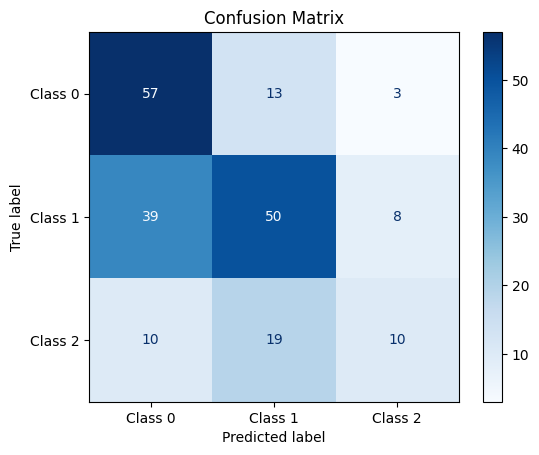

In [13]:
if __name__ == '__main__':
    data_dir = '/kaggle/input/medical'
    
    train_df = pd.read_csv('/kaggle/input/medical/data/train.csv')
    val_df = pd.read_csv('/kaggle/input/medical/data/val.csv')
    test_df = pd.read_csv('/kaggle/input/medical/data/test.csv')

    def balance_classes(df):
        class_1 = df[df['diagnosis'] == 1].sample(min(241, len(df[df['diagnosis'] == 1])), random_state=42)
        class_2 = df[df['diagnosis'] == 2].sample(min(241, len(df[df['diagnosis'] == 2])), random_state=42)
        class_3 = df[df['diagnosis'] == 3]
        return pd.concat([class_1, class_2, class_3])
    
    train_df = balance_classes(train_df)
    
    scaler = StandardScaler()
    train_age = train_df['age_at_visit'].values.reshape(-1, 1)
    scaler.fit(train_age)
    
    for df in [train_df, val_df, test_df]:
        df['label'] = df['diagnosis'] - 1
        df['age_norm'] = scaler.transform(df['age_at_visit'].values.reshape(-1, 1)).flatten()
        df['gender'] = df['ptgender'] - 1

    train_dataset = MedicalDataset(train_df, data_dir, target_shape=(182, 182, 10), is_train=True)
    val_dataset = MedicalDataset(val_df, data_dir, target_shape=(182, 182, 10))
    test_dataset = MedicalDataset(test_df, data_dir, target_shape=(182, 182, 10))

    train_labels = train_df['label'].astype(int).values
    class_counts = np.bincount(train_labels)
    sample_weights = 1. / class_counts[train_labels]
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=16,
        sampler=WeightedRandomSampler(sample_weights, len(sample_weights)),
        num_workers=4,
        drop_last=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        num_workers=4
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = MADNet(num_classes=3).to(device)
    
    class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float).to(device)
    print(f"Class counts: {class_counts}")
    print(f"Class weights: {class_weights}")
    
    criterion = nn.CrossEntropyLoss() 
    
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', patience=5, factor=0.2
    )

    print("Starting training...")
    history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        epochs=70
    )

    print("Evaluating on test set...")
    test_labels, test_preds = evaluate_model(model, test_loader, device)
    
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, 
                              target_names=['Class 0', 'Class 1', 'Class 2']))
    
    class_names = ['Class 0', 'Class 1', 'Class 2']
    plot_confusion_matrix(test_labels, test_preds, class_names)

In [21]:
def print_full_results(model, train_loader, val_loader, test_loader, history, device, class_names):
    """
    In toàn bộ kết quả trên cả tập train, validation và test
    bao gồm các metrics và confusion matrix
    """
    print("\n" + "="*60)
    print("TỔNG HỢP KẾT QUẢ HUẤN LUYỆN")
    print("="*60)
    
    best_epoch = np.argmax(history['val_acc'])
    print(f"Epoch tốt nhất: {best_epoch+1}")
    print(f"Train Acc: {history['train_acc'][best_epoch]:.4f} | Val Acc: {history['val_acc'][best_epoch]:.4f}")
    print(f"Train Loss: {history['train_loss'][best_epoch]:.4f} | Val Loss: {history['val_loss'][best_epoch]:.4f}")
    
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP TRAIN")
    print("="*60)
    train_results = evaluate_set(model, train_loader, device, "Train", class_names)
    
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP VALIDATION")
    print("="*60)
    val_results = evaluate_set(model, val_loader, device, "Validation", class_names)
    
    print("\n" + "="*60)
    print("ĐÁNH GIÁ TRÊN TẬP TEST")
    print("="*60)
    test_results = evaluate_set(model, test_loader, device, "Test", class_names)
    
    print("\n" + "="*60)
    print("TỔNG HỢP CUỐI CÙNG")
    print("="*60)
    print(f"{'Dataset':<12} | {'Accuracy':<8} | {'F1 Score':<8} | {'Precision':<8} | {'Recall':<8}")
    print("-"*60)
    print(f"{'Train':<12} | {train_results['accuracy']:.4f}    | {train_results['f1']:.4f}    | {train_results['precision']:.4f}    | {train_results['recall']:.4f}")
    print(f"{'Validation':<12} | {val_results['accuracy']:.4f}    | {val_results['f1']:.4f}    | {val_results['precision']:.4f}    | {val_results['recall']:.4f}")
    print(f"{'Test':<12} | {test_results['accuracy']:.4f}    | {test_results['f1']:.4f}    | {test_results['precision']:.4f}    | {test_results['recall']:.4f}")
    
    return {
        'train': train_results,
        'val': val_results,
        'test': test_results
    }


In [22]:
def evaluate_set(model, loader, device, set_name, class_names):
    """Đánh giá mô hình trên một tập dữ liệu cụ thể"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc=f'Evaluating {set_name} Set'):
            inputs = {
                'mri': batch['mri'].to(device),
                'dti': batch['dti'].to(device),
                'age': batch['age'].to(device),
                'gender': batch['gender'].to(device)
            }
            labels = batch['label'].to(device)
            
            outputs = model(**inputs)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    
    print(f"{set_name} Accuracy: {accuracy:.4f}")
    print(f"{set_name} F1 Score: {f1:.4f}")
    print(f"{set_name} Precision: {precision:.4f}")
    print(f"{set_name} Recall: {recall:.4f}")
    
    print(f"\nClassification Report for {set_name} Set:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    plot_confusion_matrix(
        all_labels, 
        all_preds,
        classes=class_names,
        title=f'{set_name} Set Confusion Matrix'
    )
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'predictions': all_preds,
        'labels': all_labels
    }

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()
    plt.close()
    
    # Tính confusion matrix chuẩn hóa
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap,
                xticklabels=classes, yticklabels=classes)
    plt.title(title + ' (Normalized)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_").lower()}_normalized.png')
    plt.show()
    plt.close()
    
    return cm


TỔNG HỢP KẾT QUẢ HUẤN LUYỆN
Epoch tốt nhất: 41
Train Acc: 0.6917 | Val Acc: 0.6566
Train Loss: 0.6118 | Val Loss: 1.1733

ĐÁNH GIÁ TRÊN TẬP TRAIN


Evaluating Train Set: 100%|██████████| 45/45 [01:35<00:00,  2.12s/it]


Train Accuracy: 0.7458
Train F1 Score: 0.7379
Train Precision: 0.7498
Train Recall: 0.7440

Classification Report for Train Set:
              precision    recall  f1-score   support

      Normal       0.58      0.77      0.66       221
         MCI       0.68      0.50      0.58       245
   Alzheimer       0.98      0.96      0.97       254

    accuracy                           0.75       720
   macro avg       0.75      0.74      0.74       720
weighted avg       0.76      0.75      0.74       720



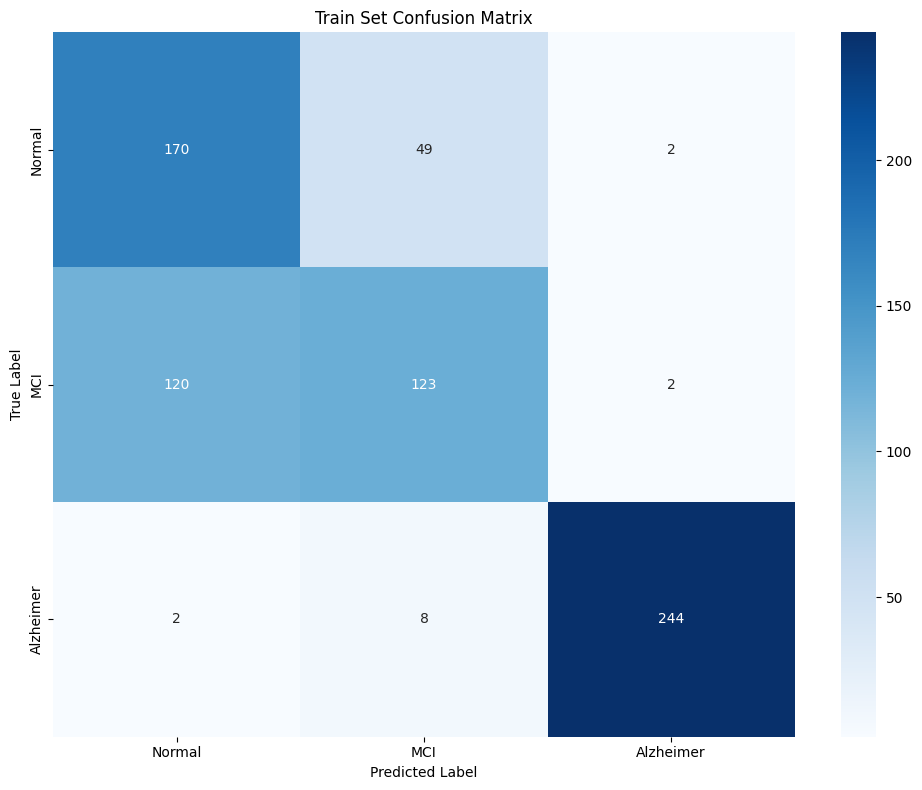

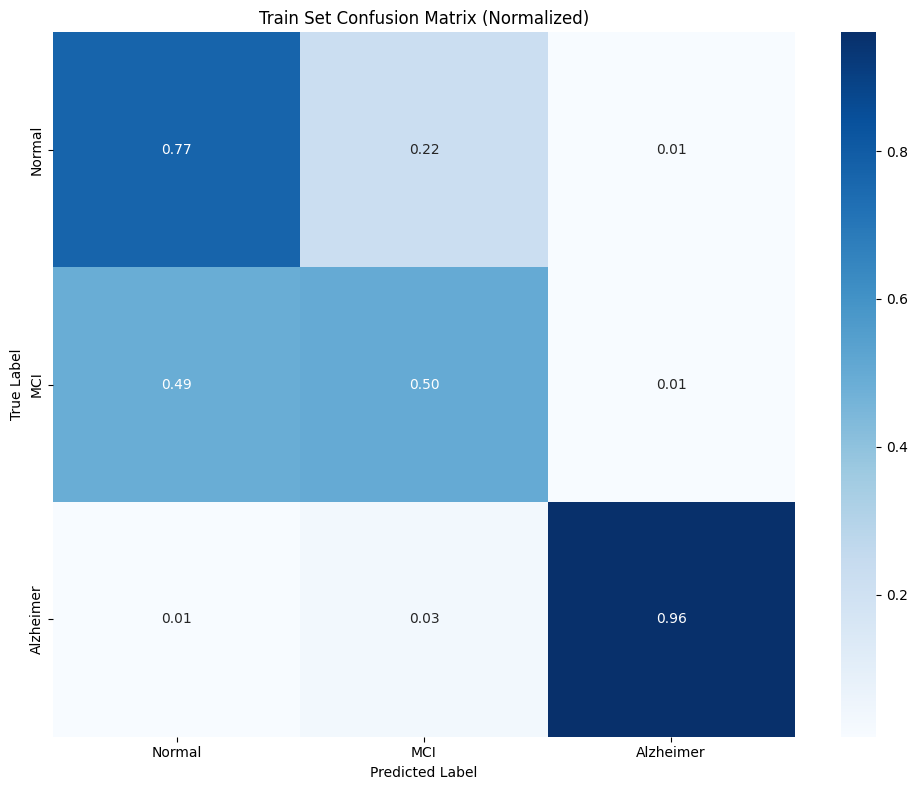


ĐÁNH GIÁ TRÊN TẬP VALIDATION


Evaluating Validation Set: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Validation Accuracy: 0.5909
Validation F1 Score: 0.4845
Validation Precision: 0.5255
Validation Recall: 0.5047

Classification Report for Validation Set:
              precision    recall  f1-score   support

      Normal       0.57      0.86      0.69        79
         MCI       0.67      0.54      0.60        83
   Alzheimer       0.33      0.11      0.17        36

    accuracy                           0.59       198
   macro avg       0.53      0.50      0.48       198
weighted avg       0.57      0.59      0.56       198



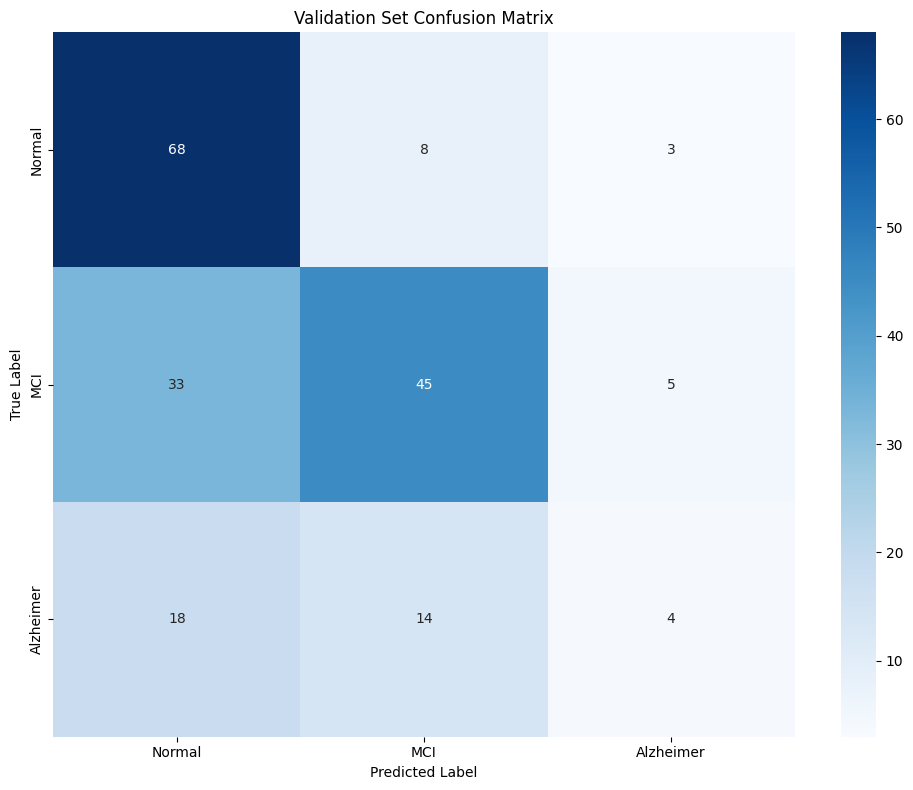

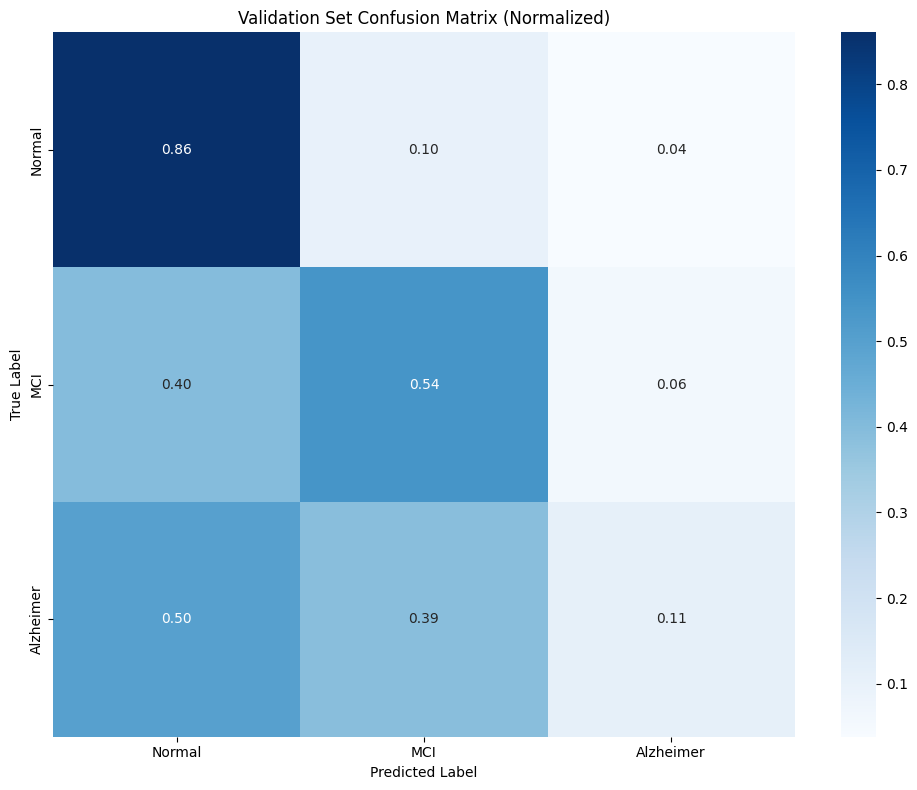


ĐÁNH GIÁ TRÊN TẬP TEST


Evaluating Test Set: 100%|██████████| 14/14 [00:25<00:00,  1.81s/it]


Test Accuracy: 0.5598
Test F1 Score: 0.5096
Test Precision: 0.5412
Test Recall: 0.5176

Classification Report for Test Set:
              precision    recall  f1-score   support

      Normal       0.54      0.78      0.64        73
         MCI       0.61      0.52      0.56        97
   Alzheimer       0.48      0.26      0.33        39

    accuracy                           0.56       209
   macro avg       0.54      0.52      0.51       209
weighted avg       0.56      0.56      0.54       209



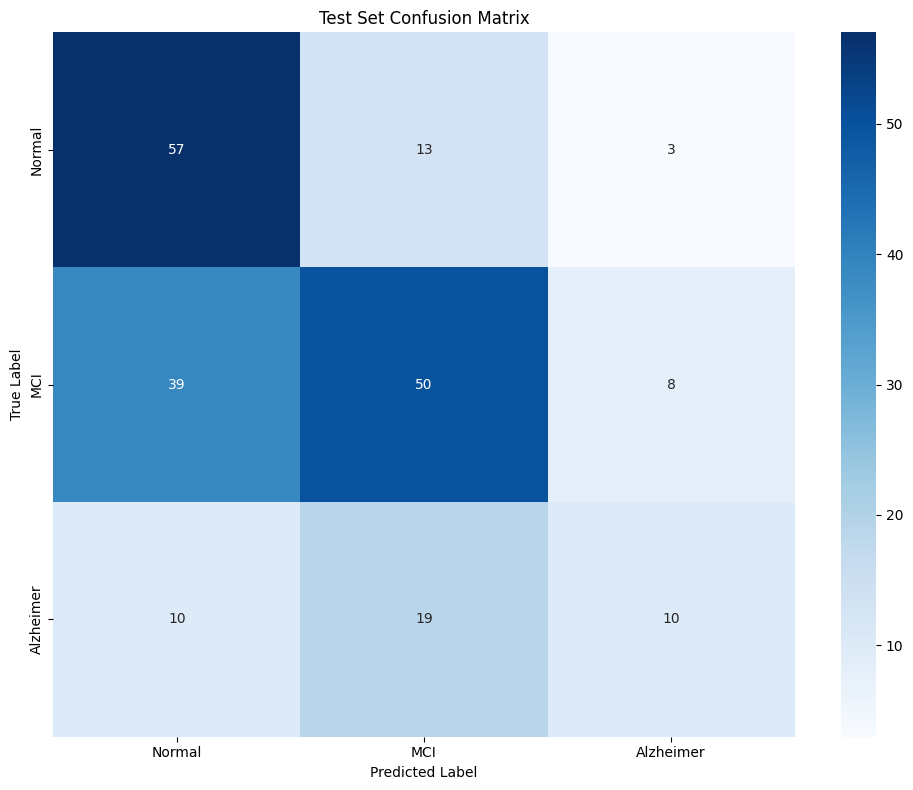

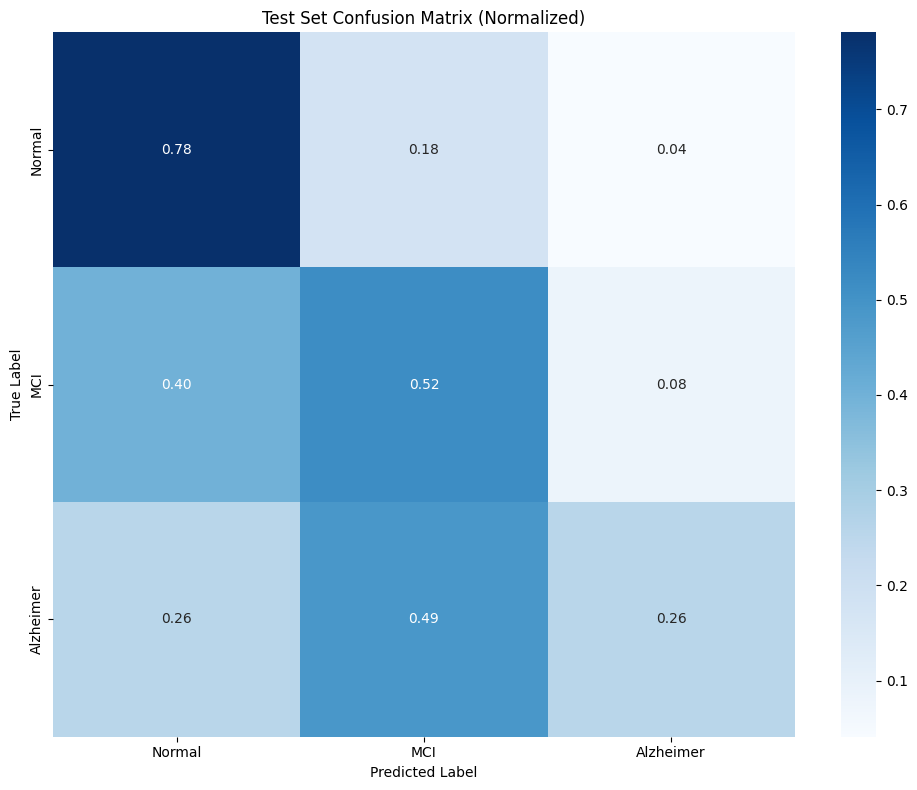


TỔNG HỢP CUỐI CÙNG
Dataset      | Accuracy | F1 Score | Precision | Recall  
------------------------------------------------------------
Train        | 0.7458    | 0.7379    | 0.7498    | 0.7440
Validation   | 0.5909    | 0.4845    | 0.5255    | 0.5047
Test         | 0.5598    | 0.5096    | 0.5412    | 0.5176


In [24]:
class_names = ['Normal', 'MCI', 'Alzheimer']

final_results = print_full_results(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    history=history,
    device=device,
    class_names=class_names
)